In [2]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Basic review of the photos directory

def dataset_analysis(path):
    subfolders = os.listdir(path)

    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  # Mode (e.g., RGB, L)
                        
                        
                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"
                        
                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")
                    
            print('--------'*10)
            print(f"Subfolder '{subfolder}' contains ({len(files)} files):")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"- {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"  - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")
                        


path = r'/kaggle/input/eye-diseases-classification/dataset'
dataset_path = path
dataset_analysis(dataset_path)


--------------------------------------------------------------------------------
Subfolder 'glaucoma' contains (1007 files):
- 906 images of format JPEG:
  - 306 images with dimensions (512, 512), bit depth 24, mode RGB
  - 600 images with dimensions (256, 256), bit depth 24, mode RGB
- 101 images of format PNG:
  - 74 images with dimensions (2592, 1728), bit depth 24, mode RGB
  - 22 images with dimensions (2464, 1632), bit depth 24, mode RGB
  - 5 images with dimensions (1848, 1224), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'normal' contains (1074 files):
- 1074 images of format JPEG:
  - 1074 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'diabetic_retinopathy' contains (1098 files):
- 1098 images of format JPEG:
  - 1098 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------

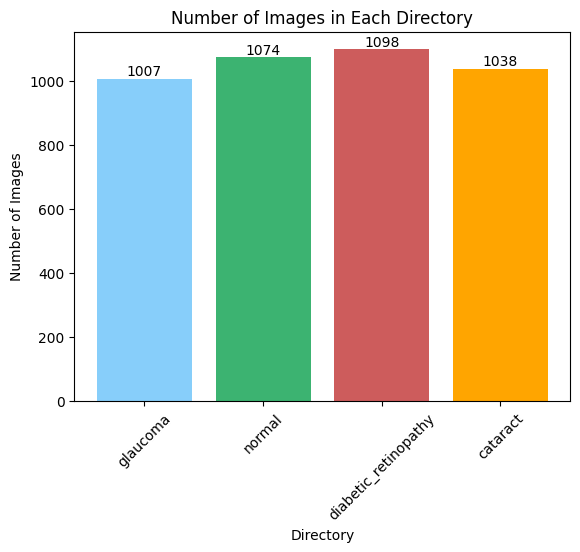

In [4]:
# Count the number of images in each directory
subfolders = os.listdir(path)

image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)
        
#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i], str(image_counts[i]), ha='center', va='bottom')
    
#Set some colors
colors = ['lightskyblue', 'mediumseagreen', 'indianred', 'orange']

# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Directory')
plt.xticks(rotation = 45)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.show()

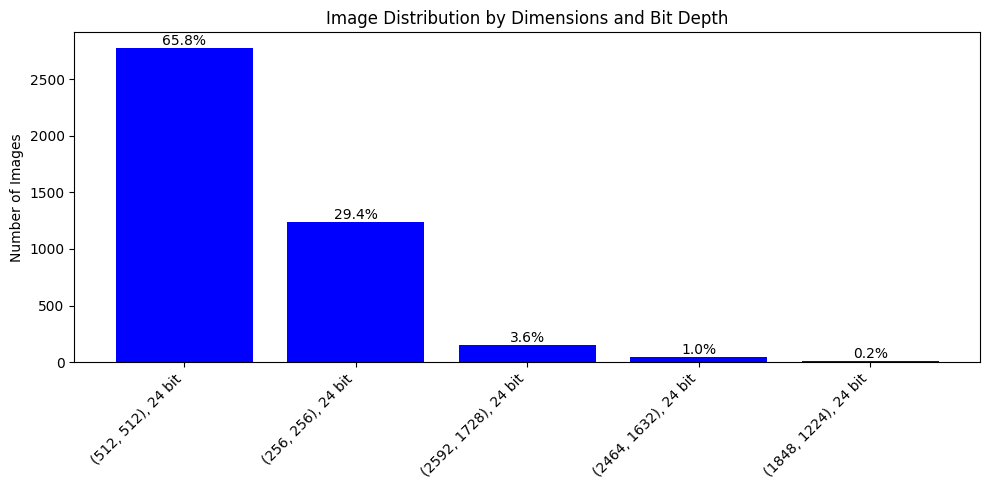

In [5]:
# Check the photos by size

def dataset_size_analysis(path):
    format_dimensions_counts = defaultdict(int)

    subfolders = os.listdir(path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_dimensions = img.size
                        image_mode = img.mode

                        # Calculate bit depth
                        bit_depth = {
                            "1": 1,
                            "L": 8,
                            "P": 8,
                            "RGB": 24,
                            "RGBA": 32,
                            "CMYK": 32
                        }.get(image_mode, "Unknown")

                        # Update counts
                        format_dimensions_counts[(image_dimensions, bit_depth)] += 1

                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Plotting dimensions and bit depths
    plt.figure(figsize=(10, 5))
    labels = [f"{dims}, {depth} bit" for (dims, depth) in format_dimensions_counts]
    sizes = list(format_dimensions_counts.values())
    total = sum(sizes)
    bars = plt.bar(labels, sizes, color='blue')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval/total:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)

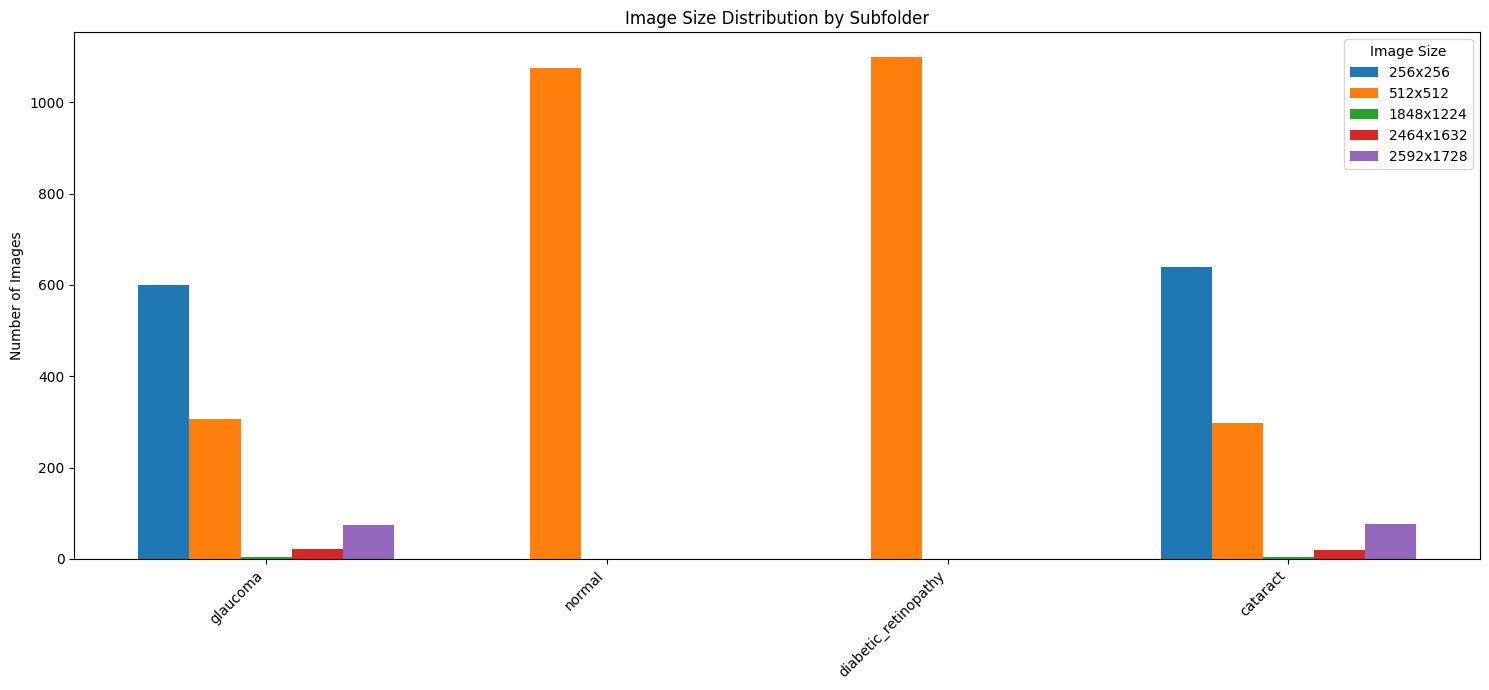

In [6]:


def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))
    
    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Size Distribution by Subfolder')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)


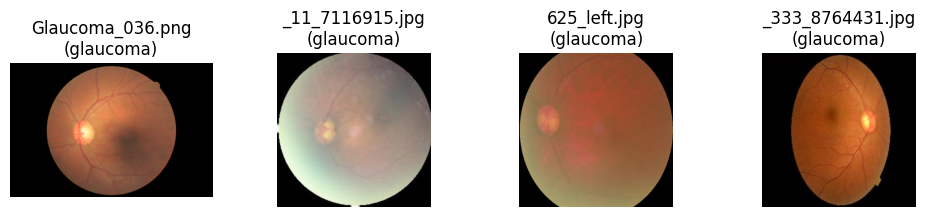

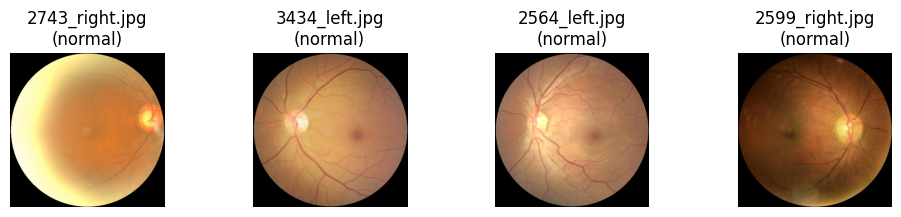

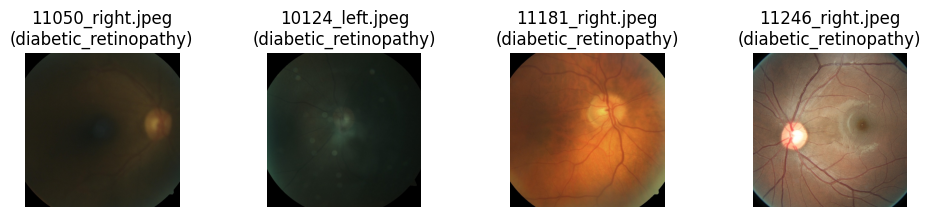

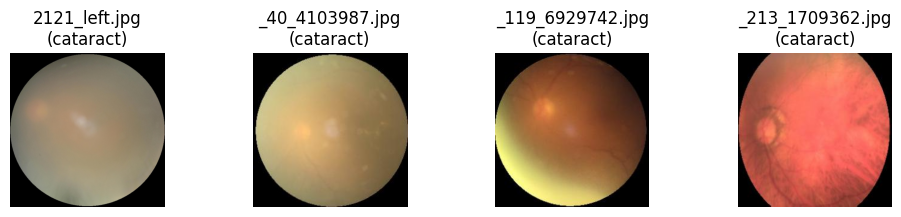

In [7]:
# Preview photos

def random_photos_from_folders(base_folder):
    # Walk through all directories and files in the base_folder
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images
            
            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))  # Create a 1x4 grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes
                
                # Extract sub-folder name from the root path
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")
                
            plt.show()

# Path to the folder containing sub-folders with images

random_photos_from_folders(path)

In [8]:
# Getting the names of classes
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# create data path and their labeles
data = []
labels = []
extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

for i in class_dirs:
    class_label = i
    image_files = []
    for ext in extensions:
        # Search for files with each extension and extend the image_files list
        image_files.extend(glob.glob(os.path.join(path, i, f"*.{ext}")))
    data.extend(image_files)
    labels.extend([class_label] * len(image_files))

# Check if lists are still empty
if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print("Files found and listed.")


# Create a DataFrame with the image paths and labels
df = pd.DataFrame({
'filename': data,
'class': labels
})


# Shuffle the dataset by rows
df = df.sample(frac=1)

Files found and listed.


In [9]:
display(df)

,filename,class
1467,/kaggle/input/eye-diseases-classification/data...,normal
902,/kaggle/input/eye-diseases-classification/data...,glaucoma
3720,/kaggle/input/eye-diseases-classification/data...,cataract
197,/kaggle/input/eye-diseases-classification/data...,glaucoma
1004,/kaggle/input/eye-diseases-classification/data...,glaucoma
...,...,...
220,/kaggle/input/eye-diseases-classification/data...,glaucoma
258,/kaggle/input/eye-diseases-classification/data...,glaucoma
2285,/kaggle/input/eye-diseases-classification/data...,diabetic_retinopathy
4048,/kaggle/input/eye-diseases-classification/data...,cataract


In [10]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


In [11]:
display(df)

,filename,class
1467,/kaggle/input/eye-diseases-classification/data...,3
902,/kaggle/input/eye-diseases-classification/data...,2
3720,/kaggle/input/eye-diseases-classification/data...,0
197,/kaggle/input/eye-diseases-classification/data...,2
1004,/kaggle/input/eye-diseases-classification/data...,2
...,...,...
220,/kaggle/input/eye-diseases-classification/data...,2
258,/kaggle/input/eye-diseases-classification/data...,2
2285,/kaggle/input/eye-diseases-classification/data...,1
4048,/kaggle/input/eye-diseases-classification/data...,0


In [12]:
# Check the balance of the classes
print(df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Now you have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))

class
1    0.260375
3    0.254683
0    0.246147
2    0.238795
Name: proportion, dtype: float64
------------------------------------------------------------
Training set:
class
1    0.260182
3    0.254646
0    0.245947
2    0.239225
Name: proportion, dtype: float64
------------------------------------------------------------
Validation set:
class
1    0.260664
3    0.254739
0    0.246445
2    0.238152
Name: proportion, dtype: float64
------------------------------------------------------------
Test set:
class
1    0.260664
3    0.254739
0    0.246445
2    0.238152
Name: proportion, dtype: float64


In [13]:
train_links, train_labels = train['filename'].values , train['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values

In [14]:
# Create a Function to Load and Preprocess Images
# tf.cond is a TensorFlow operation that allows for conditional execution based on the value of a tensor.


def load_and_preprocess_image(path, label, data_augmentation=True):
    # Read the image file
    image = tf.io.read_file(path)
    
    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]
    
    # Decode based on file extension using tf.cond
    def decode_jpeg():
        return tf.image.decode_jpeg(image, channels=3)
    
    def decode_png():
        return tf.image.decode_png(image, channels=3)
    
    def decode_bmp():
        return tf.image.decode_bmp(image, channels=3)
    
    def decode_gif():
        # Decode GIF and take the first frame
        return tf.squeeze(tf.image.decode_gif(image), axis=0)
    
    # Handle each format
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
            lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
            lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
            decode_jpeg)))))
    
    # Resize and normalize
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range

    # Apply data augmentation if in training mode
    if data_augmentation == True:
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)
        
        # Randomly flip the image vertically
        image = tf.image.random_flip_up_down(image)
        
        # Randomly rotate the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        
        # Randomly adjust brightness
        image = tf.image.random_brightness(image, max_delta=0.1)
        
        # Randomly zoom in
        image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
        image = tf.image.random_crop(image, size=[256, 256, 3])
        
        # Randomly adjust contrast
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        
    return image, label


In [15]:

# create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_links , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices( (val_links , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_links , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)



In [16]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy()}, Label: {label_element.numpy()}")


Data: [[[0.00286096 0.00211969 0.00110549]
  [0.00286096 0.00211969 0.00110549]
  [0.00286096 0.00211969 0.00110549]
  ...
  [0.00286096 0.00211969 0.00110549]
  [0.00286096 0.00211969 0.00110549]
  [0.00286096 0.00211969 0.00110549]]

 [[0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  ...
  [0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  [0.00286096 0.00211969 0.00110549]]

 [[0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  ...
  [0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  [0.00286096 0.00211969 0.00110549]]

 ...

 [[0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  ...
  [0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.01676078]
  [0.00286096 0.00211969 0.00110549]]

 [[0.01851624 0.01777498 0.01676078]
  [0.01851624 0.01777498 0.0167

In [17]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy().shape}, Label: {label_element.numpy()}")


Data: (256, 256, 3), Label: 2


In [18]:
#prepare your datasets for model training and evaluation

batch_size = 16

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Define the EarlyStopping callback to monitor the validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=12,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=r'/home/mojtaba/eye_diseases_classification project/saved model/best_model_custom.keras',  # Path to save the model file
    monitor='val_loss',  # Change to val_loss to monitor the validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the monitored metric has minimized
    
)

In [ ]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()



In [ ]:
# probability explanation in below function: 
# For example, if the model predicts an image as class B with a probability of 0.7 (or 70%), 
# the plot will show "Probability: 70%". 
# This means the model is 70% confident that the image belongs to class B.


def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()




# Transfer Learning

By setting `include_top=False`, the last fully connected layers are removed and only the base convolutional network is left, which is used when a pre-trained network is required to serve as a feature extractor in transfer learning setup followed by subsequent training of new top layer specific to your dataset.

When you set `base_model.trainable = True`, all the layers in the base model become trainable. In this case, these layers will have their weights updated during training. This method is often used in situations where you have a lot of training data and wish to fine-tune the entire model on your new data for perhaps better performance.

In [21]:


# Load the model pre-trained on EfficientNetB0, without the top layers
base_model = EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# set True >>> makes all the layers in the base model trainable
base_model.trainable = True


# Create your own model on top of the pre-trained model
model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Fit the model
history = model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 150,
)

Epoch 1/150


I0000 00:00:1726843262.750263     144 service.cc:145] XLA service 0x7eca1c0042f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726843262.750328     144 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/159 ━━━━━━━━━━━━━━━━━━━━ 3:38:17 83s/step - accuracy: 0.0625 - loss: 2.2795

I0000 00:00:1726843309.829353     144 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 152s 434ms/step - accuracy: 0.6185 - loss: 1.1784 - val_accuracy: 0.2464 - val_loss: 6.9347
Epoch 2/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8142 - loss: 0.5248 - val_accuracy: 0.2464 - val_loss: 6.9568
Epoch 3/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8579 - loss: 0.3990 - val_accuracy: 0.3863 - val_loss: 2.9509
Epoch 4/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8458 - loss: 0.4380 - val_accuracy: 0.3282 - val_loss: 4.0423
Epoch 5/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8758 - loss: 0.3347 - val_accuracy: 0.8104 - val_loss: 0.5694
Epoch 6/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8831 - loss: 0.3028 - val_accuracy: 0.8768 - val_loss: 0.3074
Epoch 7/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8844 - loss: 0.2859 - val_accuracy: 0.8957 - val_loss: 0.2756
Epoch 8/150
159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9030 - loss: 0.2813 - va

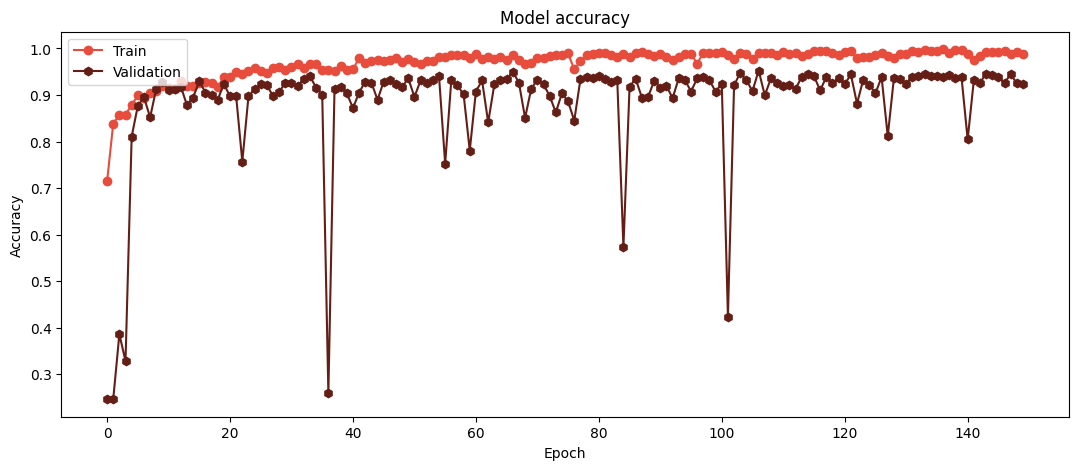

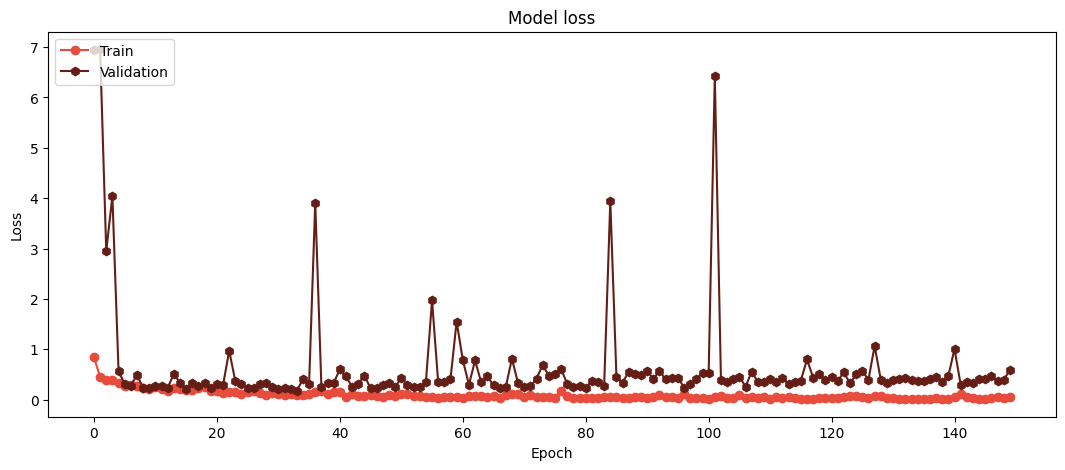

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(train_dataset)
val_loss, val_accuracy = model.evaluate(val_dataset)
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9375 - loss: 0.3597
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9267 - loss: 0.6747
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9248 - loss: 0.7619
train loss: 0.340216726064682
train accuracy: 0.9414788484573364
------------------------
val loss: 0.597296416759491
val accuracy: 0.9229857921600342
------------------------
Test loss: 0.8520525693893433
Test accuracy: 0.9135071039199829


In [28]:
# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = np.argmax( model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step
Confusion Matrix:
[[200   0   4   4]
 [  0 220   0   0]
 [ 16   1 152  32]
 [  7   0   9 199]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.90      0.96      0.93       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.92      0.76      0.83       201
              normal       0.85      0.93      0.88       215

            accuracy                           0.91       844
           macro avg       0.92      0.91      0.91       844
        weighted avg       0.92      0.91      0.91       844



Total Number Of Test data:  844


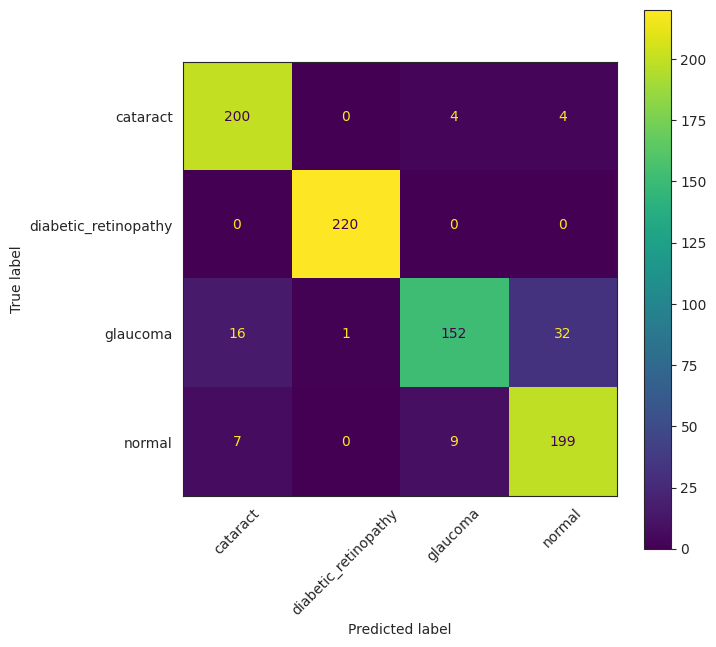

In [29]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches 
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


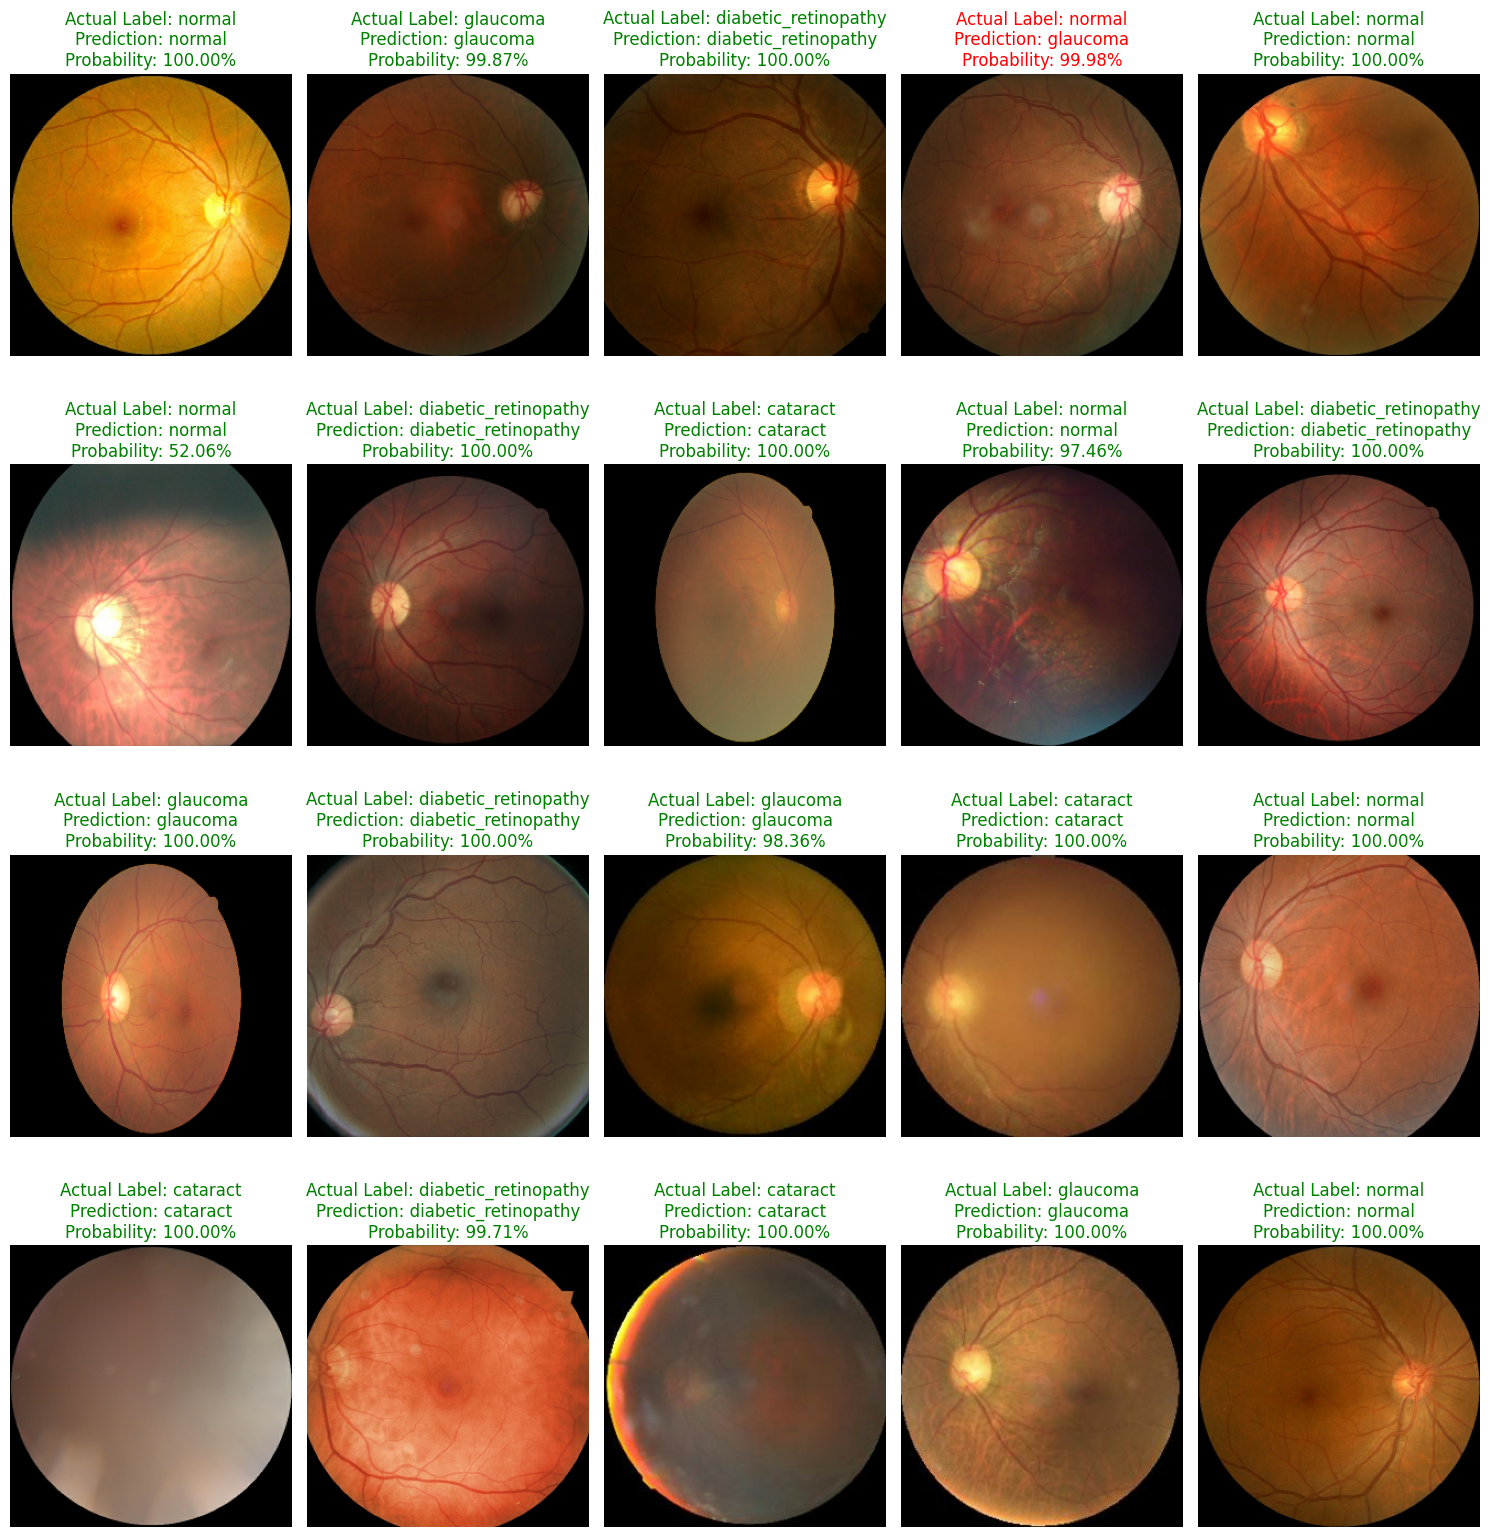

In [31]:
def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(model, test_dataset, class_labels=class_names, num_images=20)

In [32]:
model.save('best-model.h5')

In [33]:
best_model = load_model(r'/kaggle/working/best-model.h5')


In [34]:
# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9440 - loss: 0.3663
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9267 - loss: 0.6747
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9248 - loss: 0.7619
train loss: 0.33669447898864746
train accuracy: 0.9474100470542908
------------------------
val loss: 0.597296416759491
val accuracy: 0.9229857921600342
------------------------
Test loss: 0.8520525693893433
Test accuracy: 0.9135071039199829
